In [1]:
"""Script to manually redo the GODAS data to have date at centre of month
Save
1. clim of uadv, vadv, wadv, dT/dt, qnet
2. clim of currents
3. clim of temp gradients

Also get the components of advection as climatology
u' ubar dt'dx dtdxbar
"""


"Script to manually redo the GODAS data to have date at centre of month\nSave\n1. clim of uadv, vadv, wadv, dT/dt, qnet\n2. clim of currents\n3. clim of temp gradients\n\nAlso get the components of advection as climatology\nu' ubar dt'dx dtdxbar\n"

In [1]:
#import packages needed
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import os
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar


In [2]:
#function that will chnage date to middle of month. Uase differencing technique from other script.dtdt_manual
def date_to_middle(vari, varname):
    data_list = []
    if len(vari.dims) ==4:
        try:
            for i in range(len(vari.time)):
                val = ((vari[i,:,:,:]+vari[i+1,:,:,:])/(2)).values
                data_list.append(val)
        except:
            print('error')
        arr = np.asarray(data_list)
        test = xr.DataArray(arr, coords={'time': vari.time[1:], 'level': vari.level, 'lat': vari.lat, 'lon':vari.lon},
                     dims=['time', 'level', 'lat', 'lon'], attrs=dict(
                description=varname))
    elif len(vari.dims)==3:
        try:
            for i in range(len(vari.time)):
                val = ((vari[i,:,:]+vari[i+1,:,:])/(2)).values
                data_list.append(val)
        except:
            print('error')
        arr = np.asarray(data_list)
        test = xr.DataArray(arr, coords={'time': vari.time[1:], 'lat': vari.lat, 'lon':vari.lon},
                     dims=['time', 'lat', 'lon'], attrs=dict(
                description=varname))
    return test

In [3]:
#functions that get each heat budget variable calculated.
#general form so can use any dataset
def diff_T(T):
    dTdt = T.differentiate(coord = 'time',datetime_unit= 's')
    dTdx = T.differentiate('lon') / (110e3 * np.cos(T.lat * np.pi / 180))
    dTdy = T.differentiate('lat') / (110e3 )
    dTdz = (T[:,0] - T[:,-1])/float(T.level[-1])
    return dTdt[:,:-1], dTdx[:,:-1], dTdy[:,:-1], dTdz

def advection(u, v, w, dx, dy, dz):
    uadv = u*dx
    vadv = v*dy
    wadv = w*dz
    return uadv, vadv, wadv

def get_weights(INP):
    weights = INP.level
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'level': INP.level},
                 dims=['level'])
    return thickness_DA

def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('level')
    return avg


def get_clim(dict_name):
    dict1={}
    #unpack dict, get climatology, repack
    for key in dict_name.keys():
        var = dict_name[key]
        var = var.groupby('time.month').mean('time')
        dict1[key] = var
    return dict1


In [4]:
#load in GODAS
gT = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/pottmp/*.nc').pottmp
gU = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/ucur/*.nc').ucur
gV = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/vcur/*.nc').vcur
gW = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/dzdt/*.nc').dzdt
gQ = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/thflx/*.nc').thflx
gSW = xr.open_dataset('/home/z5113258/Documents/GODAS/remapcon_1/dswrf_remap.nc').dswrf

#get only to 50m
gT = gT[:,:5]
gU = gU[:,:5]
gV = gV[:,:5]
gW = gW[:,4]
#now put lat lon of uvw to T
gU = gU.assign_coords({'lat': gT.lat, 'lon': gT.lon})
gV = gV.assign_coords({'lat': gT.lat, 'lon': gT.lon})
gW = gW.assign_coords({'lat': gT.lat, 'lon': gT.lon})

In [5]:
#now perfrom on all godas data
#gT = date_to_middle(gT, 'pottmp')
#gU = date_to_middle(gU, 'ucur')
#gV = date_to_middle(gV, 'vcur')
#gW = date_to_middle(gW, 'dzdt')
#gQ = date_to_middle(gQ, 'thflx')

In [6]:
#now outpuut heta budget monthly climaotlooogy terms
dTdtg, dTdxg, dTdyg, dTdzg = diff_T(gT)

In [7]:
uadvg, vadvg, wadvg = advection(gU, gV, gW, dTdxg, dTdyg, dTdzg)

In [8]:
gqnet = (gQ-gSW*((0.67*np.exp(-50))+((1-0.67)*np.exp(-50/17))))/(3986*1026*50)

In [9]:
#calcualate weights of levels
weights = get_weights(gT)
#now get wtd avg
dTdt_gw = weighted_avg(dTdtg, weights)
uwg = weighted_avg(uadvg, weights)
vwg = weighted_avg(vadvg, weights)
wwg = wadvg

In [10]:
#alse get weighted avergae of u cur, v cur, and dtdx and dtdy
#decompose advection terms to see where the bias is coming from - temp or current
#GODAS
dTdxgw = weighted_avg(dTdxg, weights)
dTdygw = weighted_avg(dTdyg, weights)

gUw = weighted_avg(gU, weights)
gVw = weighted_avg(gV, weights)

In [11]:
#now calcaulte cliamotlogy of terms
dT_c = dTdt_gw.groupby('time.month').mean('time')
u_c = uwg.groupby('time.month').mean('time')
v_c = vwg.groupby('time.month').mean('time')
w_c = wwg.groupby('time.month').mean('time')
q_c = gqnet.groupby('time.month').mean('time')

In [12]:
dxgC = dTdxgw.groupby('time.month').mean('time')
dygC = dTdygw.groupby('time.month').mean('time')
dzgC = dTdzg.groupby('time.month').mean('time')
ugC = gUw.groupby('time.month').mean('time')
vgC = gVw.groupby('time.month').mean('time')
wgC = gW.groupby('time.month').mean('time')

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide

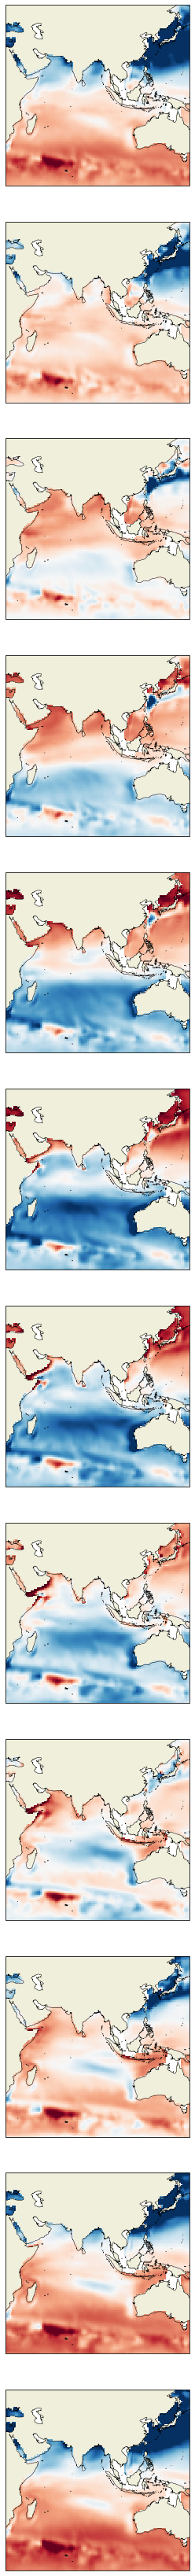

In [14]:
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(5, 60), sharey='all', sharex='all', 
                             subplot_kw={'projection':ccrs.PlateCarree()})
lons = q_c.lon
lats = q_c.lat
for i in range(0,12):
    axes[i].pcolormesh(lons, lats, q_c.sel(month = (i+1)), 
                                #levels = 41, 
                                cmap = 'RdBu_r', 
                                #add_colorbar=True, 
                                vmin = -1e-6, vmax = 1e-6, 
                                transform=ccrs.PlateCarree())
    axes[i].set_extent([30., 150., -40., 40.])
    axes[i].add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    axes[i].add_feature(cfeature.LAND)

In [13]:
#now save data
#now convert to netcdf
dT_c.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_dtdt.nc')
u_c.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_uadv.nc')
v_c.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_vadv.nc')
w_c.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_wadv.nc')
q_c.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_qnet.nc')
dxgC.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_dtdx.nc')
dygC.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_dtdy.nc')
dzgC.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_dtdz.nc')
ugC.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_ucur.nc')
vgC.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_vcur.nc')
wgC.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/climatology/GODAS_wcur.nc')



/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.

In [16]:
#load in obs U,v
NU = xr.open_dataset('/g/data/e14/sm2435/GODAS/uwnd.10m.mon.mean.nc')
NV = xr.open_dataset('/g/data/e14/sm2435/GODAS/vwnd.10m.mon.mean.nc')

In [17]:
#need to use date move fucntion
#NU = date_to_middle(NU.uwnd, 'u wind')
#NV = date_to_middle(NV.vwnd, 'v wind')

In [18]:
NUC = NU.groupby('time.month').mean('time')
NVC = NV.groupby('time.month').mean('time')
#convert to netcdf
NUC.to_netcdf('/g/data/e14/sm2435/OBSwind_u.nc')
NVC.to_netcdf('/g/data/e14/sm2435/OBSwind_v.nc')